### Clean and transform data

In [204]:
import pandas as pd
import io
import datetime
import csv

weekdays = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
column_names = ["id",
                "stop_id",
                "arrival_timestamp",
                "vehicle_id",
                "congestion_level",
                "longitude","latitude",
                "trip_id",
                "occupancy_status",
                "route_id",
                "delay",
                "timestamp"]

df = pd.read_csv('../../data/bus_updates.csv',
                 header = None, 
                 names = column_names)
df["bus_timestamp"] = pd.to_datetime(df['timestamp'], unit='s')
df['minutes'] = df.bus_timestamp.dt.hour * 60 + df.bus_timestamp.dt.minute
df['time'] = df.bus_timestamp.dt.time
df['day'] = df['bus_timestamp'].dt.weekday
df.stop_id = df.stop_id.apply(str)
# Restrict trip time slots
#df = df.loc[(df.bus_timestamp.dt.hour >= 8) & (df.bus_timestamp.dt.hour <= 21)] 

pred_col = 'congestion_level'
#pred_col = 'occupancy_status'
df2 = df[['stop_id', 'trip_id', 'minutes', 'day', pred_col]]

df2.to_csv('../../data/bus_updates_cong.csv', index=False, quoting=csv.QUOTE_NONNUMERIC);
print("Done!")

pred_col = 'occupancy_status'
df2 = df[['stop_id', 'trip_id', 'minutes', 'day', pred_col]]

df2.to_csv('../../data/bus_updates_occu.csv', index=False, quoting=csv.QUOTE_NONNUMERIC);
print("Done!!")


Done!
Done!!


### Analyse bus updates

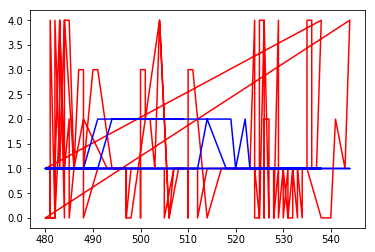

0.9306400503472414
0.7597004091329022


In [206]:
import pandas as pd
import io
import datetime
import matplotlib.pyplot as plt


def get_time_of_day(ts):
    ts = datetime.datetime.fromtimestamp(ts)
    time_of_day = ts.strftime("%H:%M:%S")
    return time_of_day

weekdays = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

column_names = ["id",
                "stop_id",
                "arrival_timestamp",
                "vehicle_id",
                "congestion_level",
                "longitude","latitude",
                "trip_id",
                "occupancy_status",
                "route_id",
                "delay",
                "timestamp"]
df = pd.read_csv('./bus_updates.csv',
                 header = None, 
                 #nrows = 20000,
                 names = column_names)
#df["time_of_day"] = df['timestamp'].apply(get_time_of_day)
df["bus_timestamp"] = pd.to_datetime(df['timestamp'], unit='s')
df['minutes'] = df.bus_timestamp.dt.hour * 60 + df.bus_timestamp.dt.minute
df['time'] = df.bus_timestamp.dt.time
df['day'] = df['bus_timestamp'].dt.weekday
#df['day'] = df.day.apply(lambda x: weekdays[x])
df.stop_id = df.stop_id.apply(str)
# Morning trips
#df = df.loc[(df.bus_timestamp.dt.hour >= 8) & (df.bus_timestamp.dt.hour <= 21)] 
# Avoid weekends
#df = df.loc[(df.bus_timestamp.dt.weekday != 5) & (df.bus_timestamp.dt.weekday != 6)]

trip_df = df.loc[df['trip_id'] == '681398']

#trip_df = df.loc[(df['stop_id'] == 201056) & (df['route_id'] == '2438_M10')]# & (df['trip_id'].isin(['681261',
                                                                                         

#trip_df.plot.scatter(x='minutes', y='congestion_level', color='red')
#trip_df.plot.scatter(x='minutes', y='occupancy_status', color='blue')
plt.plot(trip_df.minutes, trip_df.congestion_level, 'r-', label="Congestion Level")
plt.plot(trip_df.minutes, trip_df.occupancy_status, 'b-', label="Seat Occupancy")
plt.show()

'''print(df.loc[(df['stop_id'] == 203320) & (df['route_id'] == '2441_393')].vehicle_id.unique())
df.loc[(df['stop_id'] == 201056) & (df['route_id'] == '2438_M10') & (df['trip_id'].isin(['681261',
                                                                                         '681263',
                                                                                         '681264',
                                                                                         '681265',
                                                                                         '681269',
                                                                                         '681270',
                                                                                         '681271',
                                                                                         '681273',
                                                                                         '681274', 
                                                                                         '681275']))]'''

from sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import LogisticRegression
#from sklearn import svm
#from sklearn import neighbors

import numpy as np

pred_col = 'congestion_level'
#pred_col = 'occupancy_status'
df = df[['stop_id', 'trip_id', 'minutes', 'day', pred_col]]


df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75
train, test = df[df['is_train']==True], df[df['is_train']==False]

features = df.columns[:4]
y = train[pred_col]

clf = RandomForestClassifier(n_jobs=2, random_state=0)
# clf = LogisticRegression(C=1e5)
#clf = svm.SVC(C=1.0, coef0=0.0, degree=3, kernel='rbf')
#clf = neighbors.KNeighborsClassifier(15, weights='distance')
clf.fit(train[features], y)

print(clf.score(train[features], train[pred_col]))
print(clf.score(test[features], test[pred_col]))


### Analyse static timetable data

In [116]:
import pandas as pd
import datetime

'''
route_ids =  [
		"2441_391",
		"2441_393",
		"2441_395",
		"2438_M10",
		"2441_891"
	]
    
routes = pd.read_csv('../realtime-api-decode/mapping/routes.txt')
routes = routes.loc[(routes.route_id.isin(route_ids))]
routes.to_csv('./routes_filtered.csv', index=False)
routes

trips = pd.read_csv('../realtime-api-decode/mapping/trips.txt')
trips = trips.loc[(trips.route_id.isin(routes.route_id.unique()))]
trips.to_csv('./trips_filtered.csv', index=False)
trips

stop_times = pd.read_csv('../../mapping_large/stop_times.txt')
stop_times = stop_times.loc[(stop_times.trip_id.isin(trips.trip_id.unique()))]
stop_times.to_csv('./stop_times_filtered.csv', index=False)
stop_times
'''

routes = pd.read_csv('./routes_filtered.csv')

trips = pd.read_csv('./trips_filtered.csv')

stop_times = pd.read_csv('./stop_times_filtered.csv')

'''
stops = pd.read_csv('../realtime-api-decode/mapping/stops.txt')
stops = stops.loc[(stops.stop_id.isin(stop_times.stop_id.unique()))]
stops.to_csv('./stops_filtered.csv', index=False)
stops
'''

stops = pd.read_csv('./stops_filtered.csv')

stop_times['time'] = pd.to_datetime(stop_times['arrival_time'], format='%H:%M:%S').dt.time



central_stops = stops.loc[stops.stop_name.str.contains('Eddy')].stop_id.unique()
#central_stops = stops.loc[(stops.stop_name.str.contains('Eddy')) & 
#                          ((stops.stop_name.str.contains('Stand D')) | 
#                           (stops.stop_name.str.contains('Stand C')))].stop_id.unique()
central_trips = stop_times.loc[stop_times.stop_id.isin(central_stops)].trip_id.unique()
central_trips_info = trips.loc[trips.trip_id.isin(central_trips)]

stop_times = stop_times.loc[stop_times.stop_id.isin(central_stops)]

cur_time = datetime.datetime.strptime('08:10:00',"%H:%M:%S")
max_time = cur_time + datetime.timedelta(minutes = 15)
result = stop_times.loc[(stop_times.stop_id == 200054) & 
                        (stop_times.time > cur_time.time()) & 
                        (stop_times.time <= max_time.time())]

result
#trips.loc[trips.trip_id.isin(result.trip_id.unique())]
#central_stops




,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,stop_note,time
12,105642,08:20:00,08:20:00,200054,1,NaN,0,0,0,1,NaN,08:20:00
16,105644,08:22:00,08:22:00,200054,1,NaN,0,0,0,1,NaN,08:22:00
44,397076,08:21:00,08:21:00,200054,1,NaN,0,0,0,1,NaN,08:21:00
145,527166,08:15:00,08:15:00,200054,1,NaN,0,0,0,1,NaN,08:15:00
179,584026,08:12:00,08:12:00,200054,1,NaN,0,0,0,1,NaN,08:12:00
182,584027,08:14:00,08:14:00,200054,1,NaN,0,0,0,1,NaN,08:14:00
185,584028,08:16:00,08:16:00,200054,1,NaN,0,0,0,1,NaN,08:16:00
188,584029,08:22:00,08:22:00,200054,1,NaN,0,0,0,1,NaN,08:22:00
18269,647052,08:18:00,08:18:00,200054,1,NaN,0,0,0,1,NaN,08:18:00
18272,647053,08:20:00,08:20:00,200054,1,NaN,0,0,0,1,NaN,08:20:00
